# Importación de módulos

In [237]:
import pandas as pd
import numpy as np
import seaborn as sn
import plotly.express as px
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn import preprocessing
from IPython.display import display

# Importación de datos

In [238]:
# Copia los datos de un documento CSV en un DataFrame.
data_df = pd.read_csv('synchronous_machine.csv')
data_df

,Iy,PF,e,dIf,If
0,3.0,0.66,0.34,0.383,1.563
1,3.0,0.68,0.32,0.372,1.552
2,3.0,0.70,0.30,0.360,1.540
3,3.0,0.72,0.28,0.338,1.518
4,3.0,0.74,0.26,0.317,1.497
...,...,...,...,...,...
552,6.0,0.91,0.09,0.142,1.322
553,6.0,0.93,0.07,0.151,1.331
554,6.0,0.95,0.05,0.160,1.340
555,6.0,0.97,0.03,0.160,1.340


# Análisis de los datos

In [239]:
'''/* 
Recopila y muestra la información necesaria para conocer si hay outliers.
*/'''

# Retorna media, desviación estándar, min, cuantiles 25,50,75% y max.
display(data_df.describe())
# Retorna si hay valores en blanco o no numericos.
display(data_df.isna().sum())

# Establece los datos necesarios y títulos de eje para mostrar varias gráficas de caja.
figIy = px.box(data_df, y='Iy')
figIy.show()
figPF = px.box(data_df, y='PF')
figPF.show()
fige = px.box(data_df, y='e')
fige.show()
figdIf = px.box(data_df, y='dIf')
figdIf.show()
figIf = px.box(data_df, y='If')
figIf.show()

'''/* 
Function: IQR_outlier

Confirma de manera numérica la existencia de outliers.

Parameters:

    data_df - Datos recopilados del CSV.
    
Returns:

    Un DataFrame que contiene si un dato se sale de los límites calculados.
    Si un valor es igual a NaN significa que no es un outliers.
*/'''

def IQR_outlier(data_df):
    
    # Guarda el resultado del cuantil del 25%
    q1 = data_df.quantile(0.25)
    # Guarda el resultado del cuantil del 75%
    q3 = data_df.quantile(0.75)
    
    # Calcula el rango entre cuantiles
    IQR = q3-q1 
    
    ''' 
    Revisa si hay datos afuera de cada límite.
    Los limites se calculan de la siguiente manera: 
        Límite superior: q3 + (1.5*IQR)
        Límite inferior: q1 - (1.5*IQR)
    '''
    
    outliers = data_df[((data_df<(q1-1.5*IQR)) | (data_df>(q3+1.5*IQR)))]

    return outliers

# Iprime el resultado de la función anterior.
print(IQR_outlier(data_df))

,Iy,PF,e,dIf,If
count,557.000000,557.000000,557.000000,557.000000,557.000000
mean,4.499820,0.825296,0.174704,0.350659,1.530659
std,0.896024,0.103925,0.103925,0.180566,0.180566
min,3.000000,0.650000,0.000000,0.037000,1.217000
25%,3.700000,0.740000,0.080000,0.189000,1.369000
50%,4.500000,0.820000,0.180000,0.345000,1.525000
75%,5.300000,0.920000,0.260000,0.486000,1.666000
max,6.000000,1.000000,0.350000,0.769000,1.949000


Iy     0
PF     0
e      0
dIf    0
If     0
dtype: int64

     Iy  PF   e  dIf  If
0   NaN NaN NaN  NaN NaN
1   NaN NaN NaN  NaN NaN
2   NaN NaN NaN  NaN NaN
3   NaN NaN NaN  NaN NaN
4   NaN NaN NaN  NaN NaN
..   ..  ..  ..  ...  ..
552 NaN NaN NaN  NaN NaN
553 NaN NaN NaN  NaN NaN
554 NaN NaN NaN  NaN NaN
555 NaN NaN NaN  NaN NaN
556 NaN NaN NaN  NaN NaN

[557 rows x 5 columns]


# Separación de los set de datos y normalizacón
### Se va a usar una función de activación sigmoide

In [240]:
'''/* 
Esta sección prepara los datos recopilados anteriormente en subsecciones para entrenamieto y prueba.
Además de esto, normaliza los datos para poder ser ingresados a una función sigmoide.
*/'''

# Arreglo que contiene los datos de prueba dados por el profresor.
tarea_data = [[3, 0.64, 0.01, 0.031], [4.38, 0.78, 0.14, 0.402], [6, 1.01, 0.35,0.799]]
# Convierte un arreglo en DataFrame con las columnas llamadas: 'Iy', 'PF', 'e', 'dIf'.
tarea_data = pd.DataFrame(tarea_data, columns=['Iy', 'PF', 'e', 'dIf'])

# Guarda las características del conjunto de datos antes de normalizar.
train_stats = data_df.describe()

# Se transpone el DataFrame para que las columnas y filas se inviertan entre ellas.
train_stats = train_stats.transpose()
display(train_stats)

'''/* 
Function: norm

Normaliza los datos a través de una función min-max entre 0 y 1 para ser alimentados a una función sigmoide.

Parameters:

    x - Datos a normalizar.
    
Returns:

    Los datos alimentados ya normalizados.
*/'''

def norm(x):
    return((x-train_stats['min'])/(train_stats['max']-train_stats['min'])) #min-max norm

'''/* 
Function: reverse_norm

Desnormaliza los datos a través de la funcion inversa de la min-max.

Parameters:

    x - Datos normalizados a revertir.
    
Returns:

    Los datos alimentados ya desnormalizados.
*/'''

def reverse_norm(x):
    return(x*(train_stats['max']-train_stats['min'])+train_stats['min'])

# Normaliza todo el conjunto de datos
data_df = norm(data_df)

# Mueve 80% de los datos en un subconjuto de entrenamiento y los aleatoriza.
train_df = data_df.sample(frac=0.8, random_state=0)
# Mueve el restante de los datos en un subconjuto de prueba y los aleatoriza.
test_df = data_df.drop(train_df.index)
# Guarda los datos de la comlumna If en una variable para las etiquetas de entrenamiento.
train_labels = train_df.pop('If')
# Guarda los datos de la comlumna If en una variable para las etiquetas de prueba.
test_labels = test_df.pop('If')


,count,mean,std,min,25%,50%,75%,max
Iy,557.0,4.499820,0.896024,3.000,3.700,4.500,5.300,6.000
PF,557.0,0.825296,0.103925,0.650,0.740,0.820,0.920,1.000
e,557.0,0.174704,0.103925,0.000,0.080,0.180,0.260,0.350
dIf,557.0,0.350659,0.180566,0.037,0.189,0.345,0.486,0.769
If,557.0,1.530659,0.180566,1.217,1.369,1.525,1.666,1.949


# Creación del modelo

In [241]:
'''/* 
Function: my_model

Genera el modelo de regresión MLP y lo compila. El modelo consiste de lo siguiente:
    - Una capa de entradas de forma train_df.keys() que es igual a la cantidad de características.
    - Una capa oculta con ocho neuronas y como función de activación una función sigmoide.
    - Una capa oculta con ocho neuronas y como función de activación una función sigmoide.
    - Una capa de salida con una neurona y como función de activación una función sigmoide.
    - Utiliza ADAM como optimizador.
    - La función de pérdida es la Suma Cuadrática del Error.
    
Parameters:

    my_learning_rate - Razón de aprendizaje.
    
Returns:

    El modelo neuronal ya creado.
*/'''

def my_model(my_learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, input_shape=[len(train_df.keys())], activation='sigmoid'),
        tf.keras.layers.Dense(8, activation='sigmoid'),#se hace una hidden layer de 3 neuronas con activacion sigmoid
        tf.keras.layers.Dense(1, activation='sigmoid') #capa de output
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error", #funcion de perdida
                metrics=[tf.keras.metrics.MeanSquaredError()] #funcion de metricas para evaluar
                )
    
    return model

model = my_model(0.01)
model.summary()

example_batch = train_df[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 8)                 40        
                                                                 
 dense_88 (Dense)            (None, 8)                 72        
                                                                 
 dense_89 (Dense)            (None, 1)                 9         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 45ms/step


array([[0.5391102 ],
       [0.5406964 ],
       [0.5358585 ],
       [0.53981507],
       [0.54110914],
       [0.54004496],
       [0.5370686 ],
       [0.53953654],
       [0.5380878 ],
       [0.5385419 ]], dtype=float32)

# Entrenamiento del modelo

In [242]:
'''/* 
Function: train_model

Alimenta los datos correspondientes a las características y etiquetas al modelo y conduce el proceso de entrenamiento y validación.
Además de esto, también le establece al modelo la cantidad de ciclos de entrenamiento y el tamaño del batch.
Por último crea un subconjunto de validación con un 25% de los datos de entrenamiento.
    
Parameters:

    model - El modelo creado anteriormente.
    features - Conjunto que contiene las características.
    labels - Conjunto que contiene las etiquetas.
    epochs - Cantidad de ciclos de entrenamiento
    batch_size - Tamaño del batch.
    
Returns:

    Los resultados del entrenamiento.
*/'''

def train_model(model, features, labels, epochs, batch_size):
    
    history = model.fit(
        x=features,
        y=labels,
        epochs=epochs,
        batch_size = batch_size,
        validation_split=0.25,
    )
    
    # Guarda los resultados obtenidos del proceso de entrenamiento y validación en un DataFrame.
    # Estos resultados son las pérdidas y el número del ciclo correspondiente.
    hist= pd.DataFrame(history.history) #se guardan los valores de errores y metricas en un diccionario
    # Añade al DataFrame la información sobre los ciclos.
    hist['epoch'] = history.epoch
    # Guarda los datos de error en una variable para uso futuro.
    mse = hist['mean_squared_error']
    
    return hist, mse

# Ploteo de gráficas

In [243]:
'''/* 
Function: plot_loss_curve

Grafica las curvas de pérdida correspondientes al entrenamiento y la validación.
    
Parameters:

    history - Resultados provenientes del proceso de entrenamiento.
    
Returns:

    Las gráficas ya creadas.
*/'''

def plot_loss_curve(history):
    hist = history
    # Cambia los títulos de cada columna que contiene los pérdida por una versión más legible.  
    labels = {"mean_squared_error":"Training Loss", "val_mean_squared_error":"Validation Loss"}
    hist.rename(columns = labels, inplace = True)
    
    # Crea la figura, establece los títulos de eje y la paleta de colors
    fig = px.line(hist, x='epoch', y=['Training Loss', 'Validation Loss'],
                title='Gráficas de Pérdida de Entrenamiento y Evaluación',
                labels={"epoch": "Epoch", "value":"Mean Square Error", "variable":"Curvas de Pérdida"},
                color_discrete_map={ # replaces default color mapping by value
                "Training Loss": "#46039f", "Validation Loss": "#fb9f3a"})
    # Actualiza el tema de la gráfica.
    fig.update_layout(template='plotly_white')
    fig.show()

'''/* 
Function: plot_predictions

Grafica las etiquetas de prueba contra las predicciones hechas por la red neuronal.
    
Parameters:

    test_labels - Etiquetas de prueba.
    test_predictions - Predicciones de los datos de prueba
    
Returns:

    La gráfica ya creadas.
*/'''

def plot_predictions(predictions):
    
    test_labels = predictions[['If']].copy()
    test_predictions = predictions[['If Predictions']].copy()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [If]')
    plt.ylabel('Predictions [If]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([1.2,plt.xlim()[1]])
    plt.ylim([1.2,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

# Hyperparámetros

In [244]:
learning_rate = 0.03
epochs = 70
batch_size = 5

# Llamado de funciones

In [245]:
# Llama a la función para crear el modelo y lo guarda.
model = my_model(learning_rate)
# Invoca a la función de entrenamiento y guarda los resultados.
history, mse = train_model(model, train_df, train_labels, epochs, batch_size)
# Llama a la función de las gráficas.
plot_loss_curve(history)
display(history)

Epoch 1/75
67/67 [==============================] - 2s 3ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2/75
67/67 [==============================] - 0s 1ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/75
67/67 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 4/75
67/67 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/75
67/67 [==============================] - 0s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 6/75
67/67 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 7/75
67/67 [======================

,loss,Training Loss,val_loss,Validation Loss,epoch
0,0.031142,0.031142,0.006452,0.006452,0
1,0.005675,0.005675,0.003757,0.003757,1
2,0.004115,0.004115,0.005448,0.005448,2
3,0.003492,0.003492,0.002752,0.002752,3
4,0.002648,0.002648,0.002387,0.002387,4
...,...,...,...,...,...
70,0.000161,0.000161,0.000094,0.000094,70
71,0.000278,0.000278,0.000438,0.000438,71
72,0.000161,0.000161,0.000099,0.000099,72
73,0.000080,0.000080,0.000081,0.000081,73


# Predicciones

4/4 [==============================] - 0s 666us/step


,If,If Predictions
0,1.563,1.561747
1,1.401,1.401005
2,1.490,1.490583
3,1.373,1.370928
4,1.498,1.499072
...,...,...
106,1.647,1.644844
107,1.369,1.372752
108,1.862,1.870912
109,1.893,1.885073


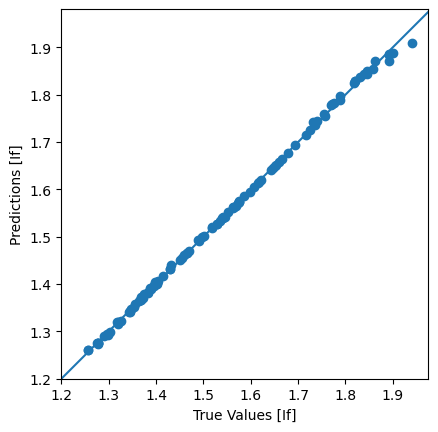

In [246]:
# Hace predicciones usando el conjunto de datos de prueba.
test_predictions = model.predict(test_df).flatten()

pivot = np.zeros((111,4))
pivot = np.insert(pivot, 4, test_labels, axis =1)
pivot2 = np.zeros((111,5))
for i in range(111):
    for j in range(5):
        pivot2[i,4] = test_predictions[i]

# Guarda las predicciones en un DataFrame.
test_predictions_df1 = pd.DataFrame(pivot, columns=['Iy', 'PF', 'e', 'dIf', 'If'])
test_predictions_df2 = pd.DataFrame(pivot2, columns=['Iy', 'PF', 'e', 'dIf', 'If'])

# Desnormaliza las predicciones y los labels.
test_predictions_df1 = reverse_norm(test_predictions_df1)
test_predictions_df2 = reverse_norm(test_predictions_df2)

# Renombra la columna "If" por "If Predictions" en el dataframe de las predicciones
test_predictions_df2.rename(columns = {'If':'If Predictions'}, inplace = True)
test_predictions_df = pd.concat([test_predictions_df1['If'], test_predictions_df2['If Predictions']], axis= 1)

# Llama a la función que grafica las predicciones sobre los datos.
plot_predictions(test_predictions_df)

display(test_predictions_df)